# Тестирование эпсилон-жадного алгоритма

In [1]:
import os
os.chdir('../')

In [2]:
import random

from simple_bandits import test_algorithm, BernoulliArm, EpsilonGreedy, test_eg_standard

Чтобы показать вам, как использовать этот фреймворк для тестирования, нам нужно передать конкретный алгоритм и конкретный набор рук. В приведенном ниже коде мы покажем, что происходит при применении алгоритма **Epsilon-Greedy** с пятью руками Бернулли. Для простоты мы воспроизвели весь необходимый код ниже, включая переопределение пяти рук Бернулли:

```python
def test_eg_standard(filename: str = 'eg_standard_results.tsv'):
    random.seed(1)
    means = [0.1, 0.1, 0.1, 0.1, 0.9]
    n_arms = len(means)
    random.shuffle(means)
    arms = list(map(lambda mu: BernoulliArm(mu), means))
    print("Best arm is " + str(ind_max(means)))

    f = open(f"{filename}", "w")

    for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
        algo = EpsilonGreedy(epsilon, [], [])
        algo.initialize(n_arms)
        
        results = test_algorithm(
            algo=algo,
            arms=arms,
            num_sims=5000,
            horizon=250)

        for i in range(len(results[0])):
            f.write(str(epsilon) + "\t")
            f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

    f.close()
    ```

В итоге, мы делаем следущее:

- В список means передаем конверси для каждой из рук. В данном случае видно, что 4 руки одинаковые, а одна самая лучшая
- Так как в списке 5 значений, то и рук 5
- arms - это тоже список, но уже моделей рук. Модель руки в данном случае - рука Бернулли с заданной вероятностью из means

- После базовой конфигурации мы протестируем алгоритм **Epsilon-Greedy** при разном epsilon
- Для каждого epsilon тестируем каждого бандита:
    - 5000 раз (num_sims=5000)
    - горизонт означает, что время работы каждого бандита 250 итераций

Таким рбразом, 5 вариантов бандита, 250 итераций будет работать каждый бандит, каждого бандита запускаем 5000 раз, чтобы усреднить результаты. Получаем 6 250 000 записей в финальном файле.

In [3]:
test_eg_standard(filename = './output/eg_standard_results.tsv')

Best arm is 2


In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('./output/eg_standard_results.tsv', sep='\t', header=None)
df.columns = ['epsilon', 'sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards']
df.head(2)

,epsilon,sim_nums,times,chosen_arms,rewards,cumulative_rewards
0,0.1,1,1,0,0.0,0.0
1,0.1,1,2,0,0.0,0.0


- **epsilon** - доля исследования
- **sim_nums** - номер симуляции
- **times** - номер итерации
- **chosen_arms** - выбранная рука
- **rewards** - награда
- **cumulative_rewards** - кумулятивная награда

In [7]:
df.shape

(6250000, 6)

In [6]:
df['chosen_arms'][(df['epsilon'] == 0.1)&(df['sim_nums'] == 1)].value_counts()

chosen_arms
2    189
0     50
1      4
3      4
4      3
Name: count, dtype: int64

# Анализ результатов исследования

Имея на руках результаты симуляционного исследования, мы можем проанализировать наши данные несколькими различными способами, чтобы оценить эффективность наших алгоритмов.

## Подход 1: отслеживание вероятности выбора лучшей руки

Первый аналитический подход, и, конечно, самый простой, заключается в отслеживании вероятности того, что что наш алгоритм выбирает лучшую руку в любой момент времени.

Нам нужно работать с вероятностями по двум разным причинам:
- 1) алгоритм использует случайность при выборе руки, которую нужно тянуть, и поэтому может не выбрать лучшую руку даже после того, как узнает, какая рука лучше
- 2) вознаграждения, которые получает алгоритм, тоже случайны. По этим причинам всегда есть вероятность того, что алгоритм не примет наилучшего решения в каждом конкретном испытании.

Поэтому мы явно рассчитаем вероятность выбора лучшей руки, оценив процент случаев, когда алгоритм выбирал лучшую руку в наших симуляциях. Если вероятность того, что алгоритм выберет лучшую руку, не увеличивается с течением времени, то у нас у нас нет никаких доказательств того, что наш алгоритм узнает что-то о значениях руки. К счастью, результаты, показанные ниже, где данные разделены по эпсилон, показывают, что наш алгоритм действительно учится, независимо от того, как мы задаем значение epsilon.

In [9]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [12]:
def plot_best_proba(df: pd.DataFrame) -> None:

    kk = df[(df['chosen_arms']==2)].groupby(['epsilon', 'times', 'chosen_arms']).size().reset_index()
    kk.columns = ['epsilon', 'times', 'chosen_arms', 'count']
    kk['proba'] = kk['count']/5000

    plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['proba'][kk['epsilon'] == 0.1], label='0.1')
    plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['proba'][kk['epsilon'] == 0.2], label='0.2')
    plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['proba'][kk['epsilon'] == 0.3], label='0.3')
    plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['proba'][kk['epsilon'] == 0.4], label='0.4')
    plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['proba'][kk['epsilon'] == 0.5], label='0.5')
    plt.xlabel('Time')
    plt.ylabel('Probability of Selecting Best Arm')
    plt.title('Accuracy of the Epsilon Greedy Algorithm')
    plt.legend()
    plt.grid()
    plt.show()

    return kk

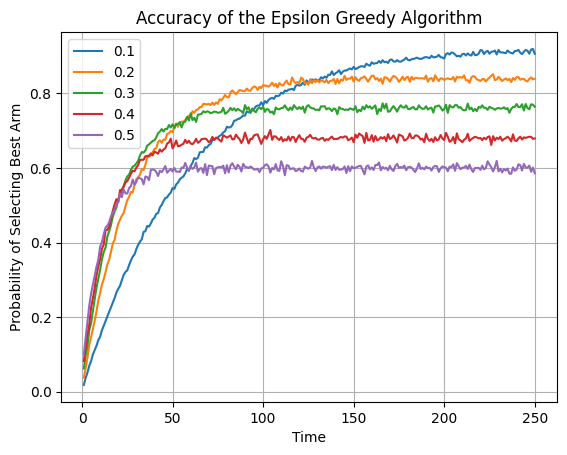

In [13]:
table = plot_best_proba(df)

In [15]:
table.head(10)

,epsilon,times,chosen_arms,count,proba
0,0.1,1,2,92,0.0184
1,0.1,2,2,186,0.0372
2,0.1,3,2,257,0.0514
3,0.1,4,2,348,0.0696
4,0.1,5,2,411,0.0822
5,0.1,6,2,500,0.1000
6,0.1,7,2,557,0.1114
7,0.1,8,2,616,0.1232
8,0.1,9,2,694,0.1388
9,0.1,10,2,737,0.1474


Как оценивается вероятность?

Очень просто! Ранее каждого бандита с определенным epsilon и 250 итерациями мы запустили 5000 раз. Мы заранее знаем, какая рука лучшая. Поэтому мы можем просто посчитать, а сколько раз выпала лучшая рука для каждой иткрации. А потом получившееся число поделить на 5000 симуляций и получить оценку вероятности. 

На графике же видно, что кривая растет (хотя и не для любого epsilon). Это говорит о том, что эпсилон-жадный алгоритм понимает, какая рука лучше, и выбирает ее все чаще и чаще.

Первое, что вы должны заметить, это то, что каждая настройка epsilon создает отдельную кривую. Кривые с высокими значениями epsilon очень быстро растут, но затем достигают пика. Это само собой разумеется, потому что алгоритм **Epsilon-Greedy** выбирает исследование или эксплуатирование случайным образом с вероятностью epsilon. **Если epsilon высок**, мы много исследуем и быстро находим лучшую руку, но затем мы продолжаем исследовать даже после того, как это уже не имеет смысла делать. Когда эпсилон высок, пиковая производительность нашей системы довольно низкая.

В отличие от высоких значений epsilon, минимальное значение epsilon, равное 0.1, заставляет алгоритм исследовать гораздо меньше, но в итоге он достигает гораздо более высокого пикового уровня производительности. Различные настройки epsilon воплощают компромисс Explore-Exploit в целом: настройки, которые приводят к большому количеству исследований, учатся быстро, но в конце не эксплуатируют достаточно часто; в то время как настройки, которые приводят к малому количеству исследований, учатся медленно, но в конце добиваются хорошего уровня производительности.

Как видите, выбор оптимального подхода зависит от того, какой момент времени вы рассматриваете. Именно поэтому всегда нужно обращать внимание на то, сколько времени мы собираемся оставить алгоритм бандита работать. Количество попыток (итераций), которые есть у алгоритма бандита, обычно называется горизонтом. **От длины горизонта сильно зависит, какой алгоритм лучше**.

## Подход 2: отслеживание среднего вознаграждения в каждый момент времени

Вместо того чтобы рассматривать вероятность выбора лучшей руки, другой простой подход к оценке эффективности нашего алгоритма заключается в использовании среднего вознаграждения, которое он получает в каждом испытании. Когда есть много рук, похожих на лучшую, каждая из которых лишь немного хуже лучшей, такой подход к среднему вознаграждению является гораздо лучшим методом анализа, чем наш подход с использованием вероятности выбора лучшей руки. Результаты этого альтернативного анализа вы можете увидеть ниже:

In [19]:
def plot_best_reward(df: pd.DataFrame) -> None:
    kk = df.groupby(['epsilon', 'times']).mean().reset_index()

    plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['rewards'][kk['epsilon'] == 0.1], label='0.1')
    plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['rewards'][kk['epsilon'] == 0.2], label='0.2')
    plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['rewards'][kk['epsilon'] == 0.3], label='0.3')
    plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['rewards'][kk['epsilon'] == 0.4], label='0.4')
    plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['rewards'][kk['epsilon'] == 0.5], label='0.5')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.title('Perfomance of the Epsilon Greedy Algorithm')
    plt.legend()
    plt.grid()
    plt.show()

    return kk

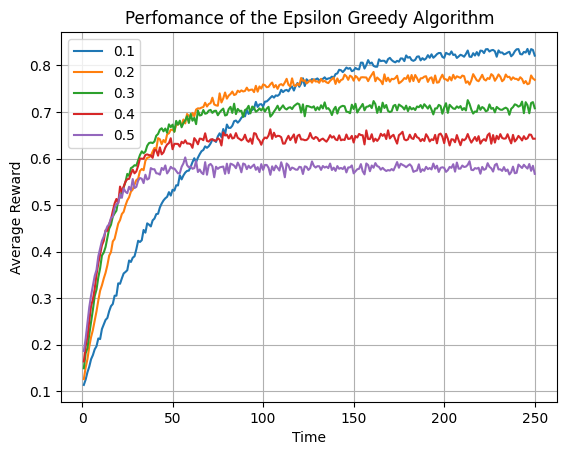

In [20]:
table = plot_best_reward(df)

In [21]:
table 

,epsilon,times,sim_nums,chosen_arms,rewards,cumulative_rewards
0,0.1,1,2500.5,0.1868,0.1138,0.1138
1,0.1,2,2500.5,0.2374,0.1252,0.2390
2,0.1,3,2500.5,0.2880,0.1410,0.3800
3,0.1,4,2500.5,0.3344,0.1530,0.5330
4,0.1,5,2500.5,0.3624,0.1690,0.7020
...,...,...,...,...,...,...
1245,0.5,246,2500.5,2.0142,0.5784,138.0768
1246,0.5,247,2500.5,1.9864,0.5882,138.6650
1247,0.5,248,2500.5,2.0164,0.5736,139.2386
1248,0.5,249,2500.5,2.0012,0.5844,139.8230


В данном конкретном случае результаты довольно похожи на предыдущий график, потому что:
- руки находятся на большом расстоянии друг от друга с точки зрения конверсий (если алгоритм выберет лучшую руку, то получит награду с вероятностью 90%, а если любую другую, то с вероятностью в 10%)
- все награды равны 0 или 1. Но в других условиях эти показатели могут отличаться гораздо сильнее

## Подход 3: отслеживание среднего кумулятивного вознаграждения в каждый момент времени

В конечном счете, в обоих рассмотренных подходах есть один недостаток: они слишком узко сфокусированы на производительности алгоритма в каждый фиксированный момент времени и не дают нам картины производительности алгоритма на протяжении всей жизни (всех 250 итераций). Этот фокус на каждой точке времени в отдельности несправедлив к версиям алгоритма **Epsilon-Greedy**, в которых epsilon велик, потому что эти алгоритмы, по определению, исследуют худшие варианты чаще, чем алгоритмы, для которых epsilon мал. Это жертва, на которую они намеренно идут, чтобы исследовать быстрее. Чтобы решить, стоит ли такое увеличение скорости поиска проблем, мы должны сосредоточиться не на производительности алгоритма в какой-то конкретный момент времени, а на его совокупной производительности с течением времени.

Для этого мы можем проанализировать кумулятивную награду наших алгоритмов, которая представляет собой просто общую сумму вознаграждения, которую алгоритм выиграл для нас до некоторого фиксированного момента времени. Кумулятивная награда важна, потому что она более справедливо относится к алгоритмам, которые проводят много исследований на начальном этапе как средство поиска наилучшей доступной руки. Как видно на рисунке ниже, анализ на основе кумулятивного вознаграждения приводит к гораздо более чистой оценке эффективности различных значений epsilon, которые мы тестировали.

In [22]:
def plot_best_cumsum_reward(df: pd.DataFrame) -> pd.DataFrame:
    kk = df.groupby(['epsilon', 'times']).mean().reset_index()

    plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['cumulative_rewards'][kk['epsilon'] == 0.1], label='0.1')
    plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['cumulative_rewards'][kk['epsilon'] == 0.2], label='0.2')
    plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['cumulative_rewards'][kk['epsilon'] == 0.3], label='0.3')
    plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['cumulative_rewards'][kk['epsilon'] == 0.4], label='0.4')
    plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['cumulative_rewards'][kk['epsilon'] == 0.5], label='0.5')
    plt.xlabel('Time')
    plt.ylabel('Average Cumulative Reward')
    plt.title('Average Cumulative Reward of the Epsilon Greedy Algorithm')
    plt.legend()
    plt.grid()
    plt.show()

    return kk

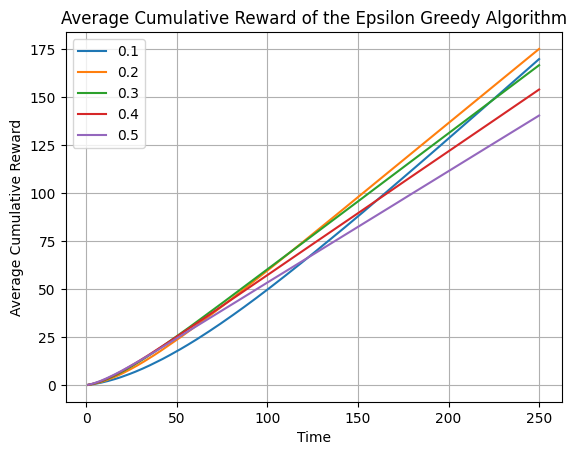

In [23]:
table = plot_best_cumsum_reward(df)

In [45]:
table[['epsilon', 'times', 'cumulative_rewards']][table['times'] == 250]

,epsilon,times,cumulative_rewards
249,0.1,250,169.7834
499,0.2,250,175.0638
749,0.3,250,166.5976
999,0.4,250,153.9322
1249,0.5,250,140.3902


На самом деле, если посмотреть на средние кумулятивные результаты, то можно увидеть, что кривые для низкого значения epsilon = 0,1 и высокого значения epsilon = 0,5 пересекаются примерно через 130 итераций: до этого момента хорошо было исследовать много, но после этого лучше иметь возможность больше эксплуатировать, когда алгоритм нашел лучшую руку.

Тем не менее, все наши графики передают одну и ту же основную мысль: алгоритм Epsilon-Greedy в конечном итоге определяет, какая рука лучше, независимо от того, как задан epsilon. Но время, необходимое для того, чтобы определить, какая рука лучше, во многом зависит от значения epsilon.

То, что подходит именно вам, зависит от того, как долго вы собираетесь запускать свой алгоритм и насколько разными будут тестируемые руки.